# ML vs Statistical Approach for CLV

In [2093]:
import pandas as pd
import numpy as np
from datetime import datetime

#Statistical LTV
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import calibration_and_holdout_data, summary_data_from_transaction_data

#ML Approach to LTV
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#Evaluation
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns

## Data

In [7]:
# Make the default figures a bit bigger
plt.rcParams['figure.figsize'] = (10,7) 

In [2094]:
data = pd.read_csv('CLV_raw.csv', engine='python')
data['InvoiceDate'] = pd.to_datetime(data.InvoiceDate, format = '%d/%m/%Y %H:%M')

In [2096]:
data['date'] = pd.to_datetime(data.InvoiceDate.dt.date)
data['time'] = data.InvoiceDate.dt.time
data['hour'] = data['time'].apply(lambda x: x.hour)
data['weekend'] = data['date'].apply(lambda x: x.weekday() in [5, 6])
data['dayofweek'] = data['date'].apply(lambda x: x.dayofweek)

In [2100]:
data.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date,time,hour,weekend,dayofweek
485148,577554,22114,HOT WATER BOTTLE TEA AND SYMPATHY,2,2011-11-20 15:35:00,4.25,15533.0,United Kingdom,2011-11-20,15:35:00,15,True,6
458411,575837,22998,TRAVEL CARD WALLET KEEP CALM,24,2011-11-11 11:37:00,0.42,12748.0,United Kingdom,2011-11-11,11:37:00,11,False,4
513868,579605,22555,PLASTERS IN TIN STRONGMAN,6,2011-11-30 12:01:00,1.65,15024.0,United Kingdom,2011-11-30,12:01:00,12,False,2
473334,576828,22450,SILK PURSE BABUSHKA BLUE,1,2011-11-16 14:36:00,3.35,NaN,United Kingdom,2011-11-16,14:36:00,14,False,2
178408,552232,22489,PACK OF 12 TRADITIONAL CRAYONS,2,2011-05-06 15:54:00,0.83,NaN,United Kingdom,2011-05-06,15:54:00,15,False,4


373 days 00:00:00


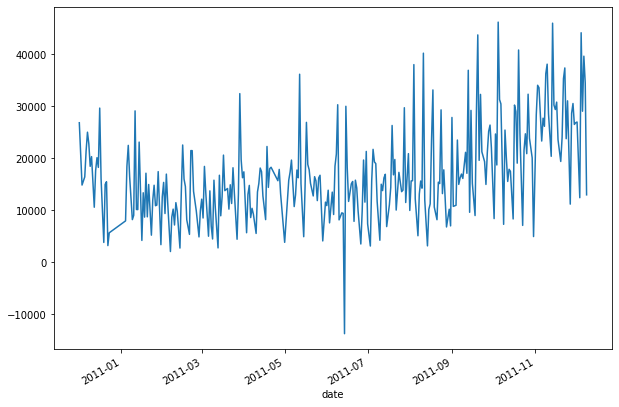

In [2101]:
data.groupby('date')['Quantity'].sum().plot()
print(data['date'].max() - data['date'].min())

So, I have around 1 year of data. Because the ML approach requires time periods for feature creation, training targets, and validation targets, I'll split it into the following segments:
1. Training Features Period - from 2011-01-01 until 2011-06-11
2. Training Target Period - from 2011-06-12 until 2011-09-09
3. Testing Features Period - from 2011-04-02 until 2011-09-10
4. Testing Target Period - from 2011-09-11 until 2011-12-09

In [2106]:
#Dataset info
print(f'Total Number of Purchases: {data.shape[0]}')
print(f'Total Number of transactions: {data.InvoiceNo.nunique()}')
print(f'Total Unique Days: {data.date.nunique()}')
print(f'Total Unique Customers: {data.CustomerID.nunique()}')
print(f"We are predicting {(data['date'].max() - datetime(2011, 9, 11)).days} days")

Total Number of Purchases: 541909
Total Number of transactions: 25900
Total Unique Days: 305
Total Unique Customers: 4372
We are predicting 89 days


## Baseline: BG/NBD + Gamma-Gamma model

BG/NDB and Gamma-Gamma models are statistical models that model the purchasing behaviour (transactions and the average order value) by fitting different types of distributions. This type of modelling requires the data on transaction level, so let's first aggregate the dataset by the invoice. I'll be aggregating the transactional revenue which is simply calculated as the quantity times the item price.

### Data Prep

In [2109]:
#Get revenue column
data['Revenue'] = data['Quantity'] * data['UnitPrice']

#Context data for the revenue (date & customerID)
id_lookup = data[['CustomerID', 'InvoiceNo', 'date']].drop_duplicates()
id_lookup.index = id_lookup['InvoiceNo']
id_lookup = id_lookup.drop('InvoiceNo', axis=1)

transactions_data = pd.DataFrame(data.groupby('InvoiceNo')['Revenue'].sum()).join(id_lookup)

In [2110]:
transactions_data.head()

,Revenue,CustomerID,date
InvoiceNo,,,
536365,139.12,17850.0,2010-12-01
536366,22.20,17850.0,2010-12-01
536367,278.73,13047.0,2010-12-01
536368,70.05,13047.0,2010-12-01
536369,17.85,13047.0,2010-12-01


In [1570]:

# #predict revenue of only those that have purchased in the specified period for comparisonrelevant_ids = transactions_data.loc[(pd.to_datetime(transactions_data.date) >='2011-03-09') &(pd.to_datetime(transactions_data.date) <= '2011-09-10'), 'CustomerID'].unique()
# relevant_transations = transactions_data.loc[transactions_data['CustomerID'].isin(relevant_ids), :]

`lifetimes` package has a utility function to split the data and aggregate the features into RFM format. So here, I'm going to use it to save some time, but if the data is large, it makes sense to do this yourselve.

In [2111]:
#Spit into train - test
rfm_train_test = calibration_and_holdout_data(transactions_data, 'CustomerID', 'date',
                                        calibration_period_end='2011-09-10',
                                        monetary_value_col = 'Revenue')   

#Selecting only customers with positive value in the calibration period (otherwise Gamma-Gamma model doesn't work)
rfm_train_test = rfm_train_test.loc[rfm_train_test['monetary_value_cal'] > 0, :]

In [2112]:
print(rfm_train_test.shape)
rfm_train_test.head()

(1965, 7)


,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
CustomerID,,,,,,,
12347.0,4.0,238.0,277.0,519.7675,2.0,759.570000,90
12348.0,2.0,110.0,268.0,297.2200,1.0,310.000000,90
12352.0,3.0,34.0,206.0,101.5600,3.0,314.743333,90
12356.0,1.0,80.0,235.0,481.4600,1.0,58.350000,90
12359.0,3.0,142.0,241.0,970.8100,2.0,1392.800000,90


### Modelling

Now, we can use the RFM calibration data to train the models.

In [2113]:
#Train the BG/NBD model
bgf = BetaGeoFitter(penalizer_coef=0.1)
bgf.fit(rfm_train_test['frequency_cal'], rfm_train_test['recency_cal'], rfm_train_test['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 1965 subjects, a: 0.01, alpha: 45.52, b: 0.17, r: 1.00>

To fit Gamma-Gamma model, we first need to make sure that the monetary value and frequency are not correlated as this is one of the basi assumptions of the model.

In [2114]:
#Train Gamma-Gamma
rfm_train_test[['monetary_value_cal', 'frequency_cal']].corr()

,monetary_value_cal,frequency_cal
monetary_value_cal,1.00000,0.15412
frequency_cal,0.15412,1.00000


They are not, so we can continue with fitting

In [2115]:
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(rfm_train_test['frequency_cal'],
        rfm_train_test['monetary_value_cal'])


<lifetimes.GammaGammaFitter: fitted with 1965 subjects, p: 1.29, q: 3.71, v: 708.57>

### Prediction

Prediction is done in three steps:
1. Predict the expected number of transactions
2. Predict the average order value
3. Multiply number of transations by the average order value

In [2116]:
#Predict the expected number of transactions in the next 89 days
predicted_bgf = bgf.predict(89,
                        rfm_train_test['frequency_cal'], 
                        rfm_train_test['recency_cal'], 
                        rfm_train_test['T_cal'])
trans_pred = predicted_bgf.fillna(0)

#Predict the average order value
monetary_pred = ggf.conditional_expected_average_profit(rfm_train_test['frequency_cal'],
                                        rfm_train_test['monetary_value_cal'])

#Putting it all together
sales_pred = trans_pred * monetary_pred

### Evaluation

In [2118]:
actual = rfm_train_test['monetary_value_holdout'] *  rfm_train_test['frequency_holdout']

In [2119]:
def evaluate(actual, sales_prediction):
    print(f"Total Sales Actual: {np.round(actual.sum())}")
    print(f"Total Sales Predicted: {np.round(sales_prediction.sum())}")
    print(f"Individual R2 score: {r2_score(actual, sales_prediction)} ")
    print(f"Individual Mean Absolute Error: {mean_absolute_error(actual, sales_prediction)}")
    plt.scatter(sales_prediction, actual)
    plt.xlabel('Prediction')
    plt.ylabel('Actual')      
    plt.show()
      

Total Sales Actual: 1742804.0
Total Sales Predicted: 1397434.0
Individual R2 score: 0.6691278084377583 
Individual Mean Absolute Error: 556.7639109686517


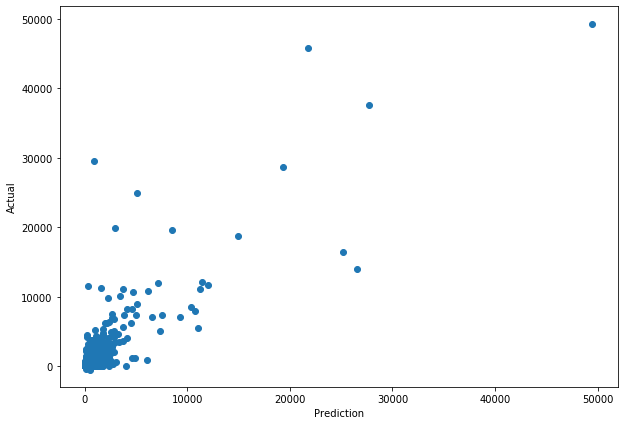

In [2120]:
evaluate(actual, sales_pred)

It seems like the model does a fairly good job at predicting the customer's revenue for the next 3 months. Let's take a look if we can get similar performance from the Machine Learning approach.

## ML Approach

This approach differs from statistical one, in a sense that it doesn't fit a distribution for latent parameters, but models the conditional expectations explicitly. I'm going to be using a small Deep Neural Network because it does quite a good job at implicit feature engineering and models the interaction effects quite nicely. I'm going to split my work into 3 parts:
1. Feature engineering for train and test periods
2. Modelling
3. Evaluation

### Feature Engineering
The possibility to include additional features into the model besides the RFM is the greates advantage of this approach. However, it's also the main limitation as **your model is going to be only as good as your features**. So, make sure to spend a lot of time on this section, and experiment yourselve to find the best features.  

In [2121]:
def get_features(data, feature_start, feature_end, target_start, target_end):
    """
    Function that outputs the features and targets on the user-level.
    Inputs:
        * data - a dataframe with raw data
        * feature_start - a string start date of feature period
        * feature_end - a  string end date of feature period
        * target_start - a  string start date of target period
        * target_end - a  string end date of target period
    """
    features_data = data.loc[(data.date >= feature_start) & (data.date <= feature_end), :]
    print(f'Using data from {(pd.to_datetime(feature_end) - pd.to_datetime(feature_start)).days} days')
    print(f'To predict {(pd.to_datetime(target_end) - pd.to_datetime(target_start)).days} days')
    
    #Transactions data features
    total_rev = features_data.groupby('CustomerID')['Revenue'].sum().rename('total_revenue')
    recency = (features_data.groupby('CustomerID')['date'].max() - features_data.groupby('CustomerID')['date'].min()).apply(lambda x: x.days).rename('recency')
    frequency = features_data.groupby('CustomerID')['InvoiceNo'].count().rename('frequency')
    t = features_data.groupby('CustomerID')['date'].min().apply(lambda x: (datetime(2011, 6, 11) - x).days).rename('t')
    time_between = (t / frequency).rename('time_between')
    avg_basket_value = (total_rev / frequency).rename('avg_basket_value')
    avg_basket_size = (features_data.groupby('CustomerID')['Quantity'].sum() / frequency).rename('avg_basket_Size')
    returns = features_data.loc[features_data['Revenue'] < 0, :].groupby('CustomerID')['InvoiceNo'].count().rename('num_returns')
    hour = features_data.groupby('CustomerID')['hour'].median().rename('purchase_hour_med')
    dow = features_data.groupby('CustomerID')['dayofweek'].median().rename('purchase_dow_med')
    weekend =  features_data.groupby('CustomerID')['weekend'].mean().rename('purchase_weekend_prop')
    train_data = pd.DataFrame(index = rfm_train.index)
    train_data = train_data.join([total_rev, recency, frequency, t, time_between, avg_basket_value, avg_basket_size, returns, hour, dow, weekend])
    train_data = train_data.fillna(0)
    
    #Target data
    target_data = data.loc[(data.date >= target_start) & (data.date <= target_end), :]
    target_quant = target_data.groupby(['CustomerID'])['date'].nunique()
    target_rev = target_data.groupby(['CustomerID'])['Revenue'].sum().rename('target_rev')
    train_data = train_data.join(target_rev).fillna(0)
    
    return train_data.iloc[:, :-1], train_data.iloc[:, -1]

In [2122]:
X_train, y_train = get_features(data, '2011-01-01', '2011-06-11', '2011-06-12', '2011-09-09')

Using data from 161 days
To predict 89 days


In [2124]:
X_test, y_test = get_features(data, '2011-04-02', '2011-09-10', '2011-09-11', '2011-12-09')

Using data from 161 days
To predict 89 days


### Modelling
Here, I'm going to use a Keras API to Tensorflow to build a simple DNN. Architecture here doesn't really matter because the problem is simple and small enough. However, if you have more data, make sure to fine tune the model. Start small, and see if the performance increases as the complexity increases.

In [2193]:
#DNN
def build_model():
    model = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=[len(X_train.columns), ]),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(0.001)

    model.compile(loss='mse',
            optimizer=optimizer,
            metrics=['mae', 'mse'])
    
    return model

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [2194]:
model = build_model()
early_history = model.fit(X_train, y_train, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:3805029.8818,  mae:463.9247,  mse:3805030.0000,  val_loss:3792055.2353,  val_mae:465.9664,  val_mse:3792055.0000,  
.......................

## Evaluation

Let's see how well the model can predict the 3 next 3 months which it has never seen before. We're going to use data from the most recent period (X_test) to make sure that our forecast is as accurate as possible.

In [2195]:
#Predicting
dnn_preds = model.predict(X_test).ravel()

Total Sales Actual: 2290775.0
Total Sales Predicted: 1177451.0
Individual R2 score: 0.5391397893676604 
Individual Mean Absolute Error: 620.0541130061874


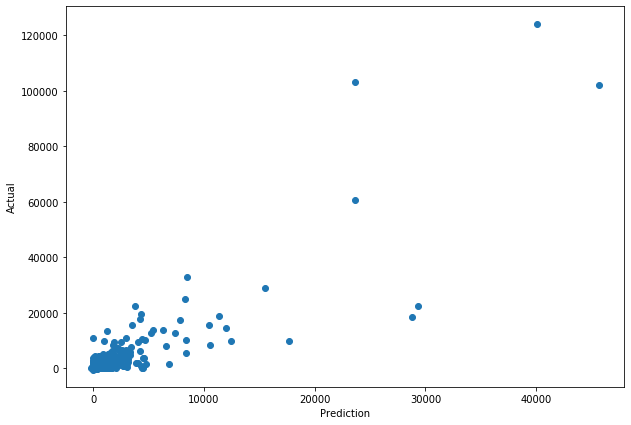

In [2196]:
#Putting the actual and predictions into the same datarame for later comparison
compare_df = pd.DataFrame(index=X_test.index)
compare_df['dnn_preds'] = dnn_preds
compare_df = compare_df.join(sales_pred.rename('stat_pred')).fillna(0)
compare_df['actual'] = y_test

evaluate(compare_df['actual'], compare_df['dnn_preds'])

We can see that the model is fairly accurate with mean absolute error comparable to the BG/NBD. Total predicted sales are a bit off, but this is largely due to the significant outliers. Let's now attempt to compare the two models

## Comparison

I'll attempt to compare the performance of DNN and BG/NBD models by looking at:
1. How well do they fit the non-outlier distribution
2. How much revenue do the top 20% of CLV customers generate

It should be noted that the datasets to train the models do differ a bit. E.g. some customer IDs had to be dropped because of their returns so the expected value was replaced by 0 in BG/NBD. Still, I'm not looking at the prediction on the user level but at the aggregate so this should not affect the evaluation. 

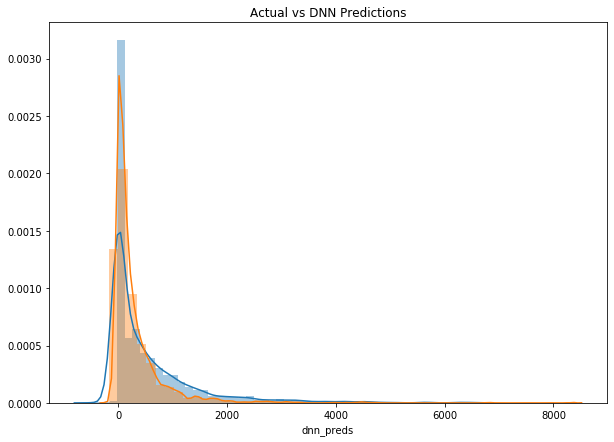

In [2197]:
#First 98% of data
no_out = compare_df.loc[(compare_df['actual'] <= np.quantile(compare_df['actual'], 0.985)), :]

sns.distplot(no_out['actual'])
sns.distplot(no_out['dnn_preds'])
plt.title('Actual vs DNN Predictions')
plt.show()

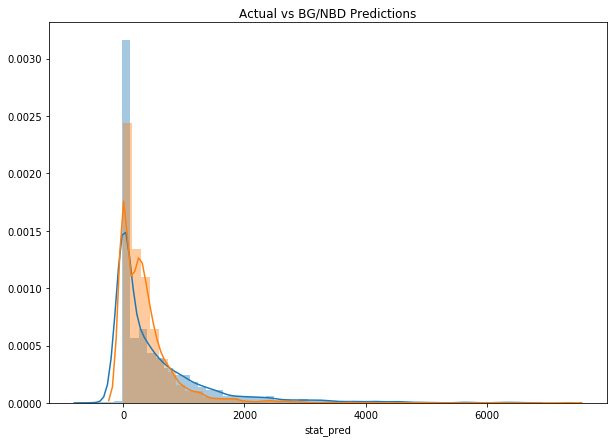

In [2198]:
sns.distplot(no_out['actual'])
sns.distplot(no_out['stat_pred'])
plt.title('Actual vs BG/NBD Predictions')
plt.show()

It looks like both models correctly model the revenue as heavily skewed with long tail. Nevertheless, DNN seems to better fit the data as it doesn't have this second spike. Let's now look at the revenue of top 20%.

In [2219]:
top_n = int(np.round(compare_df.shape[0] * 0.2))
print(f'Selecting the first {top_n} users')

#Selecting IDs
dnn_ids = compare_df['dnn_preds'].sort_values(ascending=False).index[:top_n].values
stat_ids = compare_df['stat_pred'].sort_values(ascending=False).index[:top_n].values

#Filtering the data
eval_subset = data.loc[data.date >= '2011-09-10', :]

#Sums
dnn_rev = eval_subset.loc[eval_subset.CustomerID.isin(dnn_ids), 'Revenue'].sum() 
stat_rev = eval_subset.loc[eval_subset.CustomerID.isin(stat_ids), 'Revenue'].sum()


print(f'Top 20% selected by DNN have generated {np.round(dnn_rev)}')
print(f'Top 20% selected by BG/NBD and Gamma Gamma have generated {np.round(stat_rev)}')
print(f'Thats {np.round(dnn_rev - stat_rev)} of marginal revenue')

Selecting the first 517 users
Top 20% selected by DNN have generated 1609513.0
Top 20% selected by BG/NBD and Gamma Gamma have generated 1603379.0
Thats 6134.0 of marginal revenue


The difference is only 6,134 which is quite insignificant. Hence, both methods are able to effectively pick the top 20% of most valuable customers which is not suprising, given that we've used only the transactions data in our DNN model. What about the first 10%?

In [2220]:
top_n = int(np.round(compare_df.shape[0] * 0.1))
print(f'Selecting the first {top_n} users')

#Selecting IDs
dnn_ids = compare_df['dnn_preds'].sort_values(ascending=False).index[:top_n].values
stat_ids = compare_df['stat_pred'].sort_values(ascending=False).index[:top_n].values

#Filtering the data
eval_subset = data.loc[data.date >= '2011-09-10', :]

#Sums
dnn_rev = eval_subset.loc[eval_subset.CustomerID.isin(dnn_ids), 'Revenue'].sum() 
stat_rev = eval_subset.loc[eval_subset.CustomerID.isin(stat_ids), 'Revenue'].sum()


print(f'Top 20% selected by DNN have generated {np.round(dnn_rev)}')
print(f'Top 20% selected by BG/NBD and Gamma Gamma have generated {np.round(stat_rev)}')
print(f'Thats {np.round(dnn_rev - stat_rev)} of marginal revenue')

Selecting the first 258 users
Top 20% selected by DNN have generated 1324015.0
Top 20% selected by BG/NBD and Gamma Gamma have generated 1341646.0
Thats -17631.0 of marginal revenue


With the first 10%, the DNN model is actually worse but also by only a small percentage (1.3%). Hence, the conclusion from this experiment and comparison is - **Given only the transactions data, both DNN's performance is similar to the BG/NBD + Gamma-Gamma approach**. 